# 언어 모델
## - koBERT , KoELECTRA , KcBERT , KcELECTRA

# 환경 설정 & KoBERT 설치
- https://github.com/ChangZero/koBERT-finetuning-demo/blob/main/kobert_colab.ipynb

In [3]:
# wandb 설치
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.5/189.5 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 23.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.5 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=936d231d6f7f6c96de49d3d5b59957836eef93cfc6e4bf3e7d1dbec70fc07218
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [5]:
# install and restart
!pip install mxnet
!pip install gluonnlp==0.8.0
!pip install tqdm pandas
!pip install sentencepiece
!pip install transformers
!pip install torch>=1.8.1
!pip install transformers
!pip install wandb # wandb 설치

# !pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 11.9 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gluonnlp: filename=gluonnlp-0.8.0-py3-none-any.whl size=292696 sha256=cd5036b75b5822ac0b8f5dff234ee927777f3c8098b8a65893af1d00d2c8d12d
  Stored in directory: /root/.cache/pip/wheels/2d/cc/dc/7ec84dced25f738b8be400101abb67e4b50c905090a51017e4
Successfully built gluonnlp
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import gluonnlp as nlp
from transformers import BertModel
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import datetime
import wandb
import time
from kobert_tokenizer import KoBERTTokenizer

In [7]:
# torch GPU 설정
device_type = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device_type)
device

device(type='cuda')

# git clone data

In [8]:
!git clone https://github.com/huijunam/CJ_AI_hackathon.git

Cloning into 'CJ_AI_hackathon'...
remote: Enumerating objects: 179, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 179 (delta 50), reused 76 (delta 34), pack-reused 69
Receiving objects: 100% (179/179), 28.46 MiB | 24.34 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [9]:
import pandas as pd
df_data = pd.read_csv('/content/CJ_AI_hackathon/data/final_dataset.csv')

In [10]:
df_data

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,공포
1,그냥 내 느낌일뿐겠지?,공포
2,아직너무초기라서 그런거죠?,공포
3,유치원버스 사고 낫다던데,공포
4,근데 원래이런거맞나요,공포
...,...,...
90090,얘긴 다 끝났냐? 원예부,중립
90091,"예. 그거 때문에, 부탁이 있......는......데요.",중립
90092,여자 숨겨달라는거면 사절이다.,중립
90093,아무래도 안되나요?,중립


In [11]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90095 entries, 0 to 90094
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  90095 non-null  object
 1   Emotion   90095 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


# target classes

In [12]:
target_classes ={
    '공포': 0,
    '놀람': 1,
    '분노': 2,
    '슬픔': 3,
    '중립': 4,
    '행복': 5,
    '혐오': 6
  }

In [13]:
# 레이블링
for cls in target_classes:
  df_data.loc[(df_data['Emotion'] == cls), 'Emotion'] = target_classes[cls]

In [14]:
data_list =[]
# ['sentence', 'class'] 형태로 변환
for q, label in zip(df_data['Sentence'], df_data['Emotion']):
  data =[]
  data.append(q)
  data.append(str(label))

  data_list.append(data)

print(data_list[6000])

['36도라고...미쳤다', '1']


In [ ]:
# model_list =['koBERT','KoELECTRA', 'KcBERT', 'KcELECTRA']

In [15]:
# 하이퍼 파라미터 설정
max_length = 100
batch_size = 64
warmup_ratio = 0.1
num_epochs = 5
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5
random_seed = 42

# wandb 설정

In [16]:
!wandb login 09b76e2d7910cb85b58be240c8cf088ff601d126

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [17]:
# wandb init function
def wandb_init(model,max_length=max_length,
               batch_size=batch_size,num_epochs=num_epochs,
               log_interval=log_interval,learning_rate=learning_rate,extra='',random_seed=random_seed):

  # config
  wandb.config ={
    "learning_rate": learning_rate,
    "epochs": num_epochs,
    "batch_size": batch_size,
    "seed": random_seed
  }
  # project: 폴더 이름, entity: team_5g (팀), name: 기록명
  test_time = datetime.datetime.now()
  extra ='' # 원본 데이터 일 경우
  # extra ='drop_data_' # drop data 일 경우
  wandb.init(project="KoBERT",name=f"{model}_epoch_{num_epochs}_{extra}batch_size_{batch_size}_learning_rate_{learning_rate}/{test_time}",notes=f"koBERT-epoch_{num_epochs}-batch_size_{batch_size}-random_seed{random_seed}-learning_rate_{learning_rate}", entity='team_5g')
  # loss 추적
  wandb.define_metric('train_loss', summary='min')
  wandb.define_metric('val_loss', summary='min')
  # accuracy score 추적
  wandb.define_metric('train_accuracy', summary='max')
  wandb.define_metric('val_accuracy', summary='max')


In [ ]:
# BERTSentenceTransform 수정
class BERTSentenceTransform:
    r"""BERT style data transformation.

    Parameters
    ----------
    tokenizer : BERTTokenizer.
        Tokenizer for the sentences.
    max_seq_length : int.
        Maximum sequence length of the sentences.
    pad : bool, default True
        Whether to pad the sentences to maximum length.
    pair : bool, default True
        Whether to transform sentences or sentence pairs.
    """

    def __init__(self, tokenizer, max_seq_length, vocab, pad=True, pair=True):
        self._tokenizer = tokenizer
        self._max_seq_length = max_seq_length
        self._pad = pad
        self._pair = pair
        self._vocab = vocab

    def __call__(self, line):
        """Perform transformation for sequence pairs or single sequences.

        The transformation is processed in the following steps:
        - tokenize the input sequences
        - insert [CLS], [SEP] as necessary
        - generate type ids to indicate whether a token belongs to the first
        sequence or the second sequence.
        - generate valid length

        For sequence pairs, the input is a tuple of 2 strings:
        text_a, text_b.

        Inputs:
            text_a: 'is this jacksonville ?'
            text_b: 'no it is not'
        Tokenization:
            text_a: 'is this jack ##son ##ville ?'
            text_b: 'no it is not .'
        Processed:
            tokens: '[CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]'
            type_ids: 0     0  0    0    0     0       0 0     1  1  1  1   1 1
            valid_length: 14

        For single sequences, the input is a tuple of single string:
        text_a.

        Inputs:
            text_a: 'the dog is hairy .'
        Tokenization:
            text_a: 'the dog is hairy .'
        Processed:
            text_a: '[CLS] the dog is hairy . [SEP]'
            type_ids: 0     0   0   0  0     0 0
            valid_length: 7

        Parameters
        ----------
        line: tuple of str
            Input strings. For sequence pairs, the input is a tuple of 2 strings:
            (text_a, text_b). For single sequences, the input is a tuple of single
            string: (text_a,).

        Returns
        -------
        np.array: input token ids in 'int32', shape (batch_size, seq_length)
        np.array: valid length in 'int32', shape (batch_size,)
        np.array: input token type ids in 'int32', shape (batch_size, seq_length)

        """

        # convert to unicode
        text_a = line[0]
        if self._pair:
            assert len(line) == 2
            text_b = line[1]

        tokens_a = self._tokenizer.tokenize(text_a) # 수정한 부분
        tokens_b = None

        if self._pair:
            tokens_b = self._tokenizer(text_b)

        if tokens_b:
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            self._truncate_seq_pair(tokens_a, tokens_b,
                                    self._max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > self._max_seq_length - 2:
                tokens_a = tokens_a[0:(self._max_seq_length - 2)]

        # The embedding vectors for `type=0` and `type=1` were learned during
        # pre-training and are added to the wordpiece embedding vector
        # (and position vector). This is not *strictly* necessary since
        # the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.

        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        #vocab = self._tokenizer.vocab
        vocab = self._vocab
        tokens = []
        tokens.append(vocab.cls_token)
        tokens.extend(tokens_a)
        tokens.append(vocab.sep_token)
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens.extend(tokens_b)
            tokens.append(vocab.sep_token)
            segment_ids.extend([1] * (len(tokens) - len(segment_ids)))

        input_ids = self._tokenizer.convert_tokens_to_ids(tokens)

        # The valid length of sentences. Only real  tokens are attended to.
        valid_length = len(input_ids)

        if self._pad:
            # Zero-pad up to the sequence length.
            padding_length = self._max_seq_length - valid_length
            # use padding tokens for the rest
            input_ids.extend([vocab[vocab.padding_token]] * padding_length)
            segment_ids.extend([0] * padding_length)

        return np.array(input_ids, dtype='int32'), np.array(valid_length, dtype='int32'),\
            np.array(segment_ids, dtype='int32')

In [ ]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = BERTSentenceTransform(bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)
        #transform = nlp.data.BERTSentenceTransform(
        #    tokenizer, max_seq_length=max_len, pad=pad, pair=pair)
        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

In [ ]:
# kobert 공식 git에 있는 get_kobert_model 선언
def get_kobert_model(model_path, ctx=device):
    tokenizer = KoBERTTokenizer.from_pretrained(model_path)
    bertmodel = BertModel.from_pretrained(model_path)
    device = torch.device(ctx)
    bertmodel.to(device)
    bertmodel.eval()
    vocab_b_obj = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file,
                                                         padding_token='[PAD]')
    return bertmodel, vocab_b_obj, tokenizer

In [ ]:
bertmodel, vocab, tokenizer = get_kobert_model('skt/kobert-base-v1')
# tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower = False)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [ ]:
train_list, test_list = train_test_split(data_list, test_size = 0.2, shuffle = True, random_state = random_seed)

In [ ]:
data_train = BERTDataset(train_list, 0, 1, tokenizer, vocab, max_length, True, False)
data_test = BERTDataset(test_list, 0, 1, tokenizer, vocab, max_length, True, False)

In [ ]:
# data_train[0] # 토큰화와 패딩 확인

In [ ]:
train_dataloader = torch.utils.data.DataLoader(data_train, batch_size = batch_size, num_workers = 2)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size = batch_size, num_workers = 2)

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes = len(target_classes),   # 클래스 현재 7개
                 dr_rate = None,
                 params = None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p = dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict = False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [ ]:
model = BERTClassifier(bertmodel, dr_rate = 0.5).to(device)

In [ ]:
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr = learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 loss function

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps = warmup_step, num_training_steps = t_total)

In [ ]:
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

# KoBERT 모델

In [ ]:
KoBERT_y_preds =[]
KoBERT_label_list =[]

# wandb_init
wandb_init(model='koBERT') # model_list =['koBERT','KoELECTRA', 'KcBERT', 'KcELECTRA']
# watch model
wandb.watch(model)
for e in range(num_epochs):
  train_acc = 0.0
  test_acc = 0.0
  train_loss =0.0
  test_loss =0.0

  model.train() #train
  start_time = time.time() # time

  for batch_id, (token_ids, valid_length, segment_ids, labels) in enumerate(tqdm(train_dataloader)):
    optimizer.zero_grad()
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length= valid_length
    labels = labels.long().to(device)

    y_pred = model(token_ids, valid_length, segment_ids)

    loss = loss_fn(y_pred, labels)
    loss.backward()
    # 에포크 전체 손실을 누적합니다.
    train_loss += loss.item()

    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
    optimizer.step()
    scheduler.step()  # Update learning rate schedule
    train_acc += calc_accuracy(y_pred, labels)

    if batch_id % log_interval == 0:
      print("epoch {} batch id {} loss {:.4f} train acc {:.4f}".format(e+1,batch_id+1,train_loss/(batch_id+1),train_acc/(batch_id+1)))
  # wandb log
  wandb.log({"train_acc": train_acc/len(train_dataloader)}, commit=False)
  wandb.log({"train_loss": train_loss/len(train_dataloader)}, commit=False)

  print("epoch {} train acc {:.4f}".format(e+1, train_acc / len(train_dataloader)))

  model.eval() # inference
  for batch_id, (token_ids, valid_length, segment_ids, labels) in enumerate(tqdm(test_dataloader)):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length = valid_length
    labels = labels.long().to(device)
    test_pred = model(token_ids, valid_length, segment_ids)

    KoBERT_y_preds.extend(test_pred.cpu().detach().numpy()) # for confusion matrix
    KoBERT_label_list.extend(labels.cpu().numpy()) # for confusion matrix true label

    loss = loss_fn(test_pred, labels)
    loss.backward()
    test_loss += loss.item()
    test_acc += calc_accuracy(test_pred, labels)

  # wandb log
  wandb.log({"val_acc": test_acc/len(test_dataloader)}, commit=False)
  wandb.log({"val_loss": test_loss/len(test_dataloader)})

  end_time = time.time()
  print("epoch {} test acc {:.4f}".format(e+1, test_acc / len(test_dataloader)))
  print("Time: {:.4f}sec".format((end_time - start_time)))

KoBERT_label_list = np.array(KoBERT_label_list)
KoBERT_y_preds = np.array(KoBERT_y_preds)
KoBERT_y_preds = np.argmax(KoBERT_y_preds, axis=1)

wandb: Currently logged in as: huijunam (team_5g). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.10
wandb: Run data is saved locally in /content/wandb/run-20230919_050221-gne0ihon
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run koBERT_epoch_5_batch_size_64_learning_rate_5e-05/2023-09-19 05:02:20.353576
wandb: ⭐️ View project at https://wandb.ai/team_5g/KoBERT
wandb: 🚀 View run at https://wandb.ai/team_5g/KoBERT/runs/gne0ihon


  0%|          | 0/1127 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 1.9025 train acc 0.1406
epoch 1 batch id 201 loss 1.5940 train acc 0.4421
epoch 1 batch id 401 loss 1.3839 train acc 0.5190
epoch 1 batch id 601 loss 1.2787 train acc 0.5546
epoch 1 batch id 801 loss 1.2127 train acc 0.5761
epoch 1 batch id 1001 loss 1.1668 train acc 0.5915
epoch 1 train acc 0.5992


  0%|          | 0/282 [00:00<?, ?it/s]

epoch 1 test acc 0.6695
Time: 1343.9899sec


  0%|          | 0/1127 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 0.8178 train acc 0.6875
epoch 2 batch id 201 loss 0.9659 train acc 0.6567
epoch 2 batch id 401 loss 0.9371 train acc 0.6672
epoch 2 batch id 601 loss 0.9060 train acc 0.6790
epoch 2 batch id 801 loss 0.8821 train acc 0.6877
epoch 2 batch id 1001 loss 0.8636 train acc 0.6934
epoch 2 train acc 0.6967


  0%|          | 0/282 [00:00<?, ?it/s]

epoch 2 test acc 0.6826
Time: 1351.2871sec


  0%|          | 0/1127 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 0.5575 train acc 0.8281
epoch 3 batch id 201 loss 0.7840 train acc 0.7230
epoch 3 batch id 401 loss 0.7547 train acc 0.7322
epoch 3 batch id 601 loss 0.7231 train acc 0.7448
epoch 3 batch id 801 loss 0.7001 train acc 0.7531
epoch 3 batch id 1001 loss 0.6835 train acc 0.7592
epoch 3 train acc 0.7622


  0%|          | 0/282 [00:00<?, ?it/s]

epoch 3 test acc 0.6818
Time: 1351.0989sec


  0%|          | 0/1127 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.4104 train acc 0.8594
epoch 4 batch id 201 loss 0.6040 train acc 0.7856
epoch 4 batch id 401 loss 0.5829 train acc 0.7949
epoch 4 batch id 601 loss 0.5559 train acc 0.8061
epoch 4 batch id 801 loss 0.5351 train acc 0.8134
epoch 4 batch id 1001 loss 0.5196 train acc 0.8183
epoch 4 train acc 0.8205


  0%|          | 0/282 [00:00<?, ?it/s]

epoch 4 test acc 0.6829
Time: 1351.4939sec


  0%|          | 0/1127 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.3218 train acc 0.8594
epoch 5 batch id 201 loss 0.4699 train acc 0.8340
epoch 5 batch id 401 loss 0.4565 train acc 0.8407
epoch 5 batch id 601 loss 0.4375 train acc 0.8489
epoch 5 batch id 801 loss 0.4232 train acc 0.8542
epoch 5 batch id 1001 loss 0.4163 train acc 0.8565
epoch 5 train acc 0.8573


  0%|          | 0/282 [00:00<?, ?it/s]

epoch 5 test acc 0.6760
Time: 1351.8718sec


<Figure size 800x600 with 0 Axes>

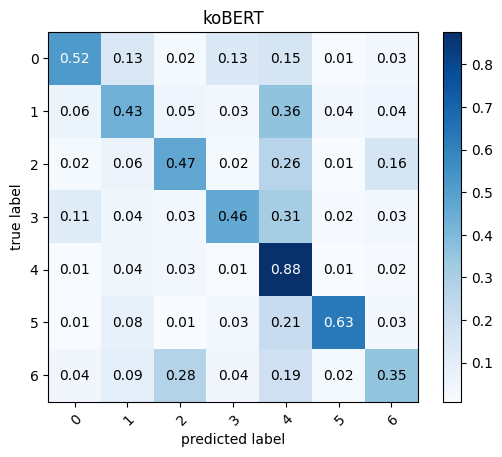

In [ ]:
show_confusion_matrix(KoBERT_label_list,KoBERT_y_preds,model_name=model_name) # confusion matrix

In [ ]:
# torch.save(model.state_dict(), "./base_model_koBERT_epoch3_.pt")

## Dataset

In [18]:
# Define a custom dataset class
class custom_dataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_length):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = self.texts[idx]
    label = self.labels[idx]
    encoding = self.tokenizer(text,padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')
    input_ids = encoding['input_ids'].squeeze() #
    attention_mask = encoding['attention_mask'].squeeze() #

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        # 'label': label
        # 'labels': torch.tensor(int(label), dtype=torch.float)
        'labels': torch.tensor(int(label), dtype=torch.long)
    }

In [19]:
train_list, test_list = train_test_split(data_list, test_size = 0.2, shuffle = True, random_state = random_seed)
train_list = pd.DataFrame(train_list, columns=['Sentence', 'Emotion'])
test_list = pd.DataFrame(test_list, columns=['Sentence', 'Emotion'])

# Load your training data
X_train = train_list['Sentence']
Y_train = train_list['Emotion']

# Load your testing data
X_test = test_list['Sentence']
Y_test = test_list['Emotion']

## train and validate function

In [20]:
def train_and_validate(model='default',model_name='default',train_data_loader='default', test_data_loader='default'):
  confusion_y_preds =[] # confusion matrix
  confusion_label_list =[] # confusion matrix
  optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
  criterion = nn.CrossEntropyLoss()

  # wandb_init
  wandb_init(model=model_name) # model_list =['koBERT','KoELECTRA', 'KcBERT', 'KcELECTRA']
  # watch model
  wandb.watch(model)

  for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    train_loss =0.0
    test_loss =0.0

    start_time = time.time() # time

    model.train() #train
    for batch_id, batch in enumerate(tqdm(train_data_loader)):
      input_ids = batch['input_ids']
      attention_mask = batch['attention_mask']
      labels = batch['labels']

      input_ids = input_ids.to(device)
      attention_mask = attention_mask.to(device)
      labels = labels.to(device)

      # 그래디언트 초기화
      optimizer.zero_grad()
      # 모델에 입력을 주어 예측을 생성합니다.
      outputs = model(input_ids, attention_mask=attention_mask)
      # 모델 출력에서 로짓(분류에 대한 점수)을 얻습니다.
      # 모델 예측
      logits = outputs.logits  # 최신 Transformers 라이브러리에서는 이렇게 사용할 수 있을 수 있음
      # 손실을 계산합니다.
      loss = criterion(logits, labels)
      # 역전파를 통해 그래디언트 계산
      loss.backward()
      # 에포크 전체 손실을 누적합니다.
      train_loss += loss.item()
      # 옵티마이저를 사용해 가중치를 업데이트
      optimizer.step()
      # 정확도
      # train_acc += calc_accuracy(np.argmax(logits.cpu().detach().numpy()), label)
      train_acc += (logits.argmax(dim=1)==labels).sum().item() / (labels.size(0))

      if batch_id % log_interval == 0:
        print("epoch {} batch id {} train loss {:.4f} train acc {:.4f}".format(e+1, batch_id+1,train_loss/(batch_id+1),train_acc/(batch_id+1)))

      # # wandb log
      # wandb.log({"train_acc": train_acc/(batch_id+1)}, commit=False)
      # wandb.log({"train_loss": train_loss/(batch_id+1)}, commit=False)

    # wandb log
    wandb.log({"train_acc": train_acc/len(train_data_loader)}, commit=False)
    wandb.log({"train_loss": train_loss/len(train_data_loader)}, commit=False)
    print("epoch {} train loss {:.4f} train acc {:.4f}".format(e+1,train_loss/(batch_id+1),train_acc/(batch_id+1)))

    # 모델 평가
    model.eval()
    with torch.no_grad():
      for batch_id, batch in enumerate(test_data_loader):
        # Validation 데이터 가져오기
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        # 모델 예측
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        confusion_y_preds.extend(logits.argmax(dim=1).cpu().numpy()) # for confusion matrix
        confusion_label_list.extend(labels.cpu().numpy()) # for confusion matrix true label

        # 손실 계산
        loss = criterion(logits,labels)
        test_loss += loss.item()

        # 정확도 계산
        test_acc += (logits.argmax(dim=1)==labels).sum().item() / (labels.size(0))
        if batch_id % log_interval == 0:
          print("epoch {} batch id {} test loss {:.4f} test acc {:.4f}".format(e+1, batch_id+1,test_loss/(batch_id+1),test_acc/(batch_id+1)))

      # wandb log
      wandb.log({"val_acc": test_acc/len(test_data_loader)},commit=False)
      wandb.log({"val_loss": test_loss/len(test_data_loader)})
      end_time = time.time()
      print("epoch {} test loss {:.4f} test acc {:.4f}".format(e+1,test_loss/(batch_id+1),test_acc/(batch_id+1)))
      print("Time: {:.4f}sec".format((end_time - start_time)))

  return np.array(confusion_label_list), np.array(confusion_y_preds)

In [21]:
def show_confusion_matrix(label_list, y_preds, model_name='default'):
  cm = confusion_matrix(label_list, y_preds)
  # Define class labels (assuming 7 classes in this example)
  class_labels = list(dict(map(reversed, target_classes.items())).keys()) # true label

  plt.figure(figsize=(8, 6))
  fig, ax = plot_confusion_matrix(conf_mat=cm, colorbar=True,
  show_absolute=False, show_normed=True, class_names=class_labels)
  plt.title(model_name)
  plt.show()

# KcBERT 모델
https://github.com/Beomi/KcBERT

In [23]:
# KcBERT 모델과 토크나이저 로드
model_name = "beomi/kcbert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

KcBERT_y_preds =[] # confusion matrix
KcBERT_label_list =[] # confusion matrix

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels =len(target_classes))
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at beomi/kcbert-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30000, 768, padding_idx=0)
      (position_embeddings): Embedding(300, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [24]:
# dataset
train_dataset = custom_dataset(X_train, Y_train, tokenizer, max_length)
test_dataset = custom_dataset(X_test, Y_test, tokenizer, max_length)

# dataloader
train_data_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_data_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [25]:
# model_name =['koBERT','KoELECTRA', 'KcBERT', 'KcELECTRA']
# wandb: 가 안뜨면 런타임 다시 시작 또는 삭제하고 !wandb login '본인 API 키' 다시 실행하고 돌려볼 것
model_name = 'KcBERT'
KcBERT_label_list, KcBERT_y_preds= train_and_validate(model=model,model_name=model_name,
                                                      train_data_loader=train_data_loader,test_data_loader=test_data_loader)

wandb: Currently logged in as: huijunam (team_5g). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.10
wandb: Run data is saved locally in /content/wandb/run-20230920_031308-drdjlcg1
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run KcBERT_epoch_5_batch_size_64_learning_rate_5e-05/2023-09-20 03:13:06.683087
wandb: ⭐️ View project at https://wandb.ai/team_5g/KoBERT
wandb: 🚀 View run at https://wandb.ai/team_5g/KoBERT/runs/drdjlcg1


  0%|          | 0/1127 [00:00<?, ?it/s]

epoch 1 batch id 1 train loss 1.8834 train acc 0.2812
epoch 1 batch id 201 train loss 1.0556 train acc 0.6296
epoch 1 batch id 401 train loss 1.0029 train acc 0.6446
epoch 1 batch id 601 train loss 0.9805 train acc 0.6526
epoch 1 batch id 801 train loss 0.9624 train acc 0.6576
epoch 1 batch id 1001 train loss 0.9525 train acc 0.6612
epoch 1 train loss 0.9457 train acc 0.6629
epoch 1 batch id 1 test loss 0.8550 test acc 0.7031
epoch 1 batch id 201 test loss 0.8935 test acc 0.6831
epoch 1 test loss 0.8936 test acc 0.6805
Time: 1185.3718sec


  0%|          | 0/1127 [00:00<?, ?it/s]

epoch 2 batch id 1 train loss 0.7700 train acc 0.7344
epoch 2 batch id 201 train loss 0.6895 train acc 0.7513
epoch 2 batch id 401 train loss 0.7127 train acc 0.7423
epoch 2 batch id 601 train loss 0.7186 train acc 0.7402
epoch 2 batch id 801 train loss 0.7226 train acc 0.7389
epoch 2 batch id 1001 train loss 0.7257 train acc 0.7383
epoch 2 train loss 0.7262 train acc 0.7373
epoch 2 batch id 1 test loss 0.8973 test acc 0.7031
epoch 2 batch id 201 test loss 0.8885 test acc 0.6816
epoch 2 test loss 0.8921 test acc 0.6819
Time: 1185.0643sec


  0%|          | 0/1127 [00:00<?, ?it/s]

epoch 3 batch id 1 train loss 0.5432 train acc 0.7969
epoch 3 batch id 201 train loss 0.4713 train acc 0.8319
epoch 3 batch id 401 train loss 0.4819 train acc 0.8262
epoch 3 batch id 601 train loss 0.4903 train acc 0.8224
epoch 3 batch id 801 train loss 0.4955 train acc 0.8217
epoch 3 batch id 1001 train loss 0.5007 train acc 0.8194
epoch 3 train loss 0.5047 train acc 0.8181
epoch 3 batch id 1 test loss 1.1680 test acc 0.6562
epoch 3 batch id 201 test loss 1.0235 test acc 0.6697
epoch 3 test loss 1.0251 test acc 0.6693
Time: 1185.8408sec


  0%|          | 0/1127 [00:00<?, ?it/s]

epoch 4 batch id 1 train loss 0.2051 train acc 0.9844
epoch 4 batch id 201 train loss 0.2779 train acc 0.9022
epoch 4 batch id 401 train loss 0.2861 train acc 0.8980
epoch 4 batch id 601 train loss 0.2927 train acc 0.8956
epoch 4 batch id 801 train loss 0.3010 train acc 0.8928
epoch 4 batch id 1001 train loss 0.3081 train acc 0.8901
epoch 4 train loss 0.3108 train acc 0.8895
epoch 4 batch id 1 test loss 1.2285 test acc 0.6875
epoch 4 batch id 201 test loss 1.2113 test acc 0.6623
epoch 4 test loss 1.2108 test acc 0.6620
Time: 1185.3472sec


  0%|          | 0/1127 [00:00<?, ?it/s]

epoch 5 batch id 1 train loss 0.1705 train acc 0.9375
epoch 5 batch id 201 train loss 0.1628 train acc 0.9447
epoch 5 batch id 401 train loss 0.1766 train acc 0.9383
epoch 5 batch id 601 train loss 0.1817 train acc 0.9368
epoch 5 batch id 801 train loss 0.1890 train acc 0.9336
epoch 5 batch id 1001 train loss 0.1939 train acc 0.9318
epoch 5 train loss 0.1972 train acc 0.9303
epoch 5 batch id 1 test loss 1.3877 test acc 0.6875
epoch 5 batch id 201 test loss 1.4939 test acc 0.6452
epoch 5 test loss 1.4946 test acc 0.6453
Time: 1186.1473sec


<Figure size 800x600 with 0 Axes>

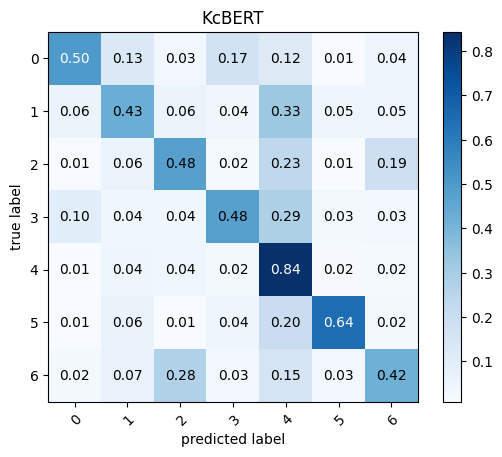

In [26]:
show_confusion_matrix(KcBERT_label_list,KcBERT_y_preds,model_name=model_name) # confusion matrix

# KcELECTRA 모델
https://github.com/Beomi/KcELECTRA

In [ ]:
# KcELECTRA 모델과 토크나이저 로드
model_name = "beomi/KcELECTRA-base-v2022"
tokenizer = AutoTokenizer.from_pretrained(model_name)
KcELECTRA_y_preds =[] # confusion matrix
KcELECTRA_label_list =[] # confusion matrix

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels =len(target_classes))
model.to(device)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(54343, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [ ]:
# dataset
train_dataset = custom_dataset(X_train, Y_train, tokenizer, max_length)
test_dataset = custom_dataset(X_test, Y_test, tokenizer, max_length)

# dataloader
train_data_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_data_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [ ]:
# model_name =['koBERT','KoELECTRA', 'KcBERT', 'KcELECTRA']
# wandb: 가 안뜨면 런타임 다시 시작 또는 삭제하고 !wandb login '본인 API 키' 다시 실행하고 돌려볼 것
model_name = 'KcELECTRA'
KcELECTRA_label_list, KcELECTRA_y_preds = train_and_validate(model=model,model_name=model_name,
                                                      train_data_loader=train_data_loader,test_data_loader=test_data_loader)

wandb: Currently logged in as: huijunam (team_5g). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.10
wandb: Run data is saved locally in /content/wandb/run-20230919_000059-7t25h14i
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run KcELECTRA_epoch_5_batch_size_64_learning_rate_5e-05/2023-09-19 00:00:57.127445
wandb: ⭐️ View project at https://wandb.ai/team_5g/KoBERT
wandb: 🚀 View run at https://wandb.ai/team_5g/KoBERT/runs/7t25h14i


  0%|          | 0/1127 [00:00<?, ?it/s]

epoch 1 batch id 1 train loss 1.9708 train acc 0.1094
epoch 1 batch id 201 train loss 1.2576 train acc 0.5756
epoch 1 batch id 401 train loss 1.0894 train acc 0.6264
epoch 1 batch id 601 train loss 1.0138 train acc 0.6498
epoch 1 batch id 801 train loss 0.9713 train acc 0.6609
epoch 1 batch id 1001 train loss 0.9449 train acc 0.6686
epoch 1 train loss 0.9297 train acc 0.6727
epoch 1 batch id 1 test loss 0.8397 test acc 0.7500
epoch 1 batch id 201 test loss 0.8032 test acc 0.7090
epoch 1 test loss 0.8004 test acc 0.7104
Time: 1244.1708sec


  0%|          | 0/1127 [00:00<?, ?it/s]

epoch 2 batch id 1 train loss 0.7244 train acc 0.6875
epoch 2 batch id 201 train loss 0.6966 train acc 0.7461
epoch 2 batch id 401 train loss 0.6931 train acc 0.7495
epoch 2 batch id 601 train loss 0.7004 train acc 0.7463
epoch 2 batch id 801 train loss 0.6996 train acc 0.7469
epoch 2 batch id 1001 train loss 0.7008 train acc 0.7467
epoch 2 train loss 0.7026 train acc 0.7462
epoch 2 batch id 1 test loss 0.8152 test acc 0.6719
epoch 2 batch id 201 test loss 0.8036 test acc 0.7108
epoch 2 test loss 0.8150 test acc 0.7098
Time: 1245.4268sec


  0%|          | 0/1127 [00:00<?, ?it/s]

epoch 3 batch id 1 train loss 0.4296 train acc 0.8594
epoch 3 batch id 201 train loss 0.5174 train acc 0.8158
epoch 3 batch id 401 train loss 0.5256 train acc 0.8127
epoch 3 batch id 601 train loss 0.5241 train acc 0.8125
epoch 3 batch id 801 train loss 0.5299 train acc 0.8100
epoch 3 batch id 1001 train loss 0.5335 train acc 0.8084
epoch 3 train loss 0.5363 train acc 0.8072
epoch 3 batch id 1 test loss 1.2032 test acc 0.6719
epoch 3 batch id 201 test loss 0.8837 test acc 0.7023
epoch 3 test loss 0.8816 test acc 0.7014
Time: 1244.1196sec


  0%|          | 0/1127 [00:00<?, ?it/s]

epoch 4 batch id 1 train loss 0.2483 train acc 0.9531
epoch 4 batch id 201 train loss 0.3334 train acc 0.8829
epoch 4 batch id 401 train loss 0.3508 train acc 0.8759
epoch 4 batch id 601 train loss 0.3575 train acc 0.8738
epoch 4 batch id 801 train loss 0.3641 train acc 0.8710
epoch 4 batch id 1001 train loss 0.3688 train acc 0.8695
epoch 4 train loss 0.3709 train acc 0.8686
epoch 4 batch id 1 test loss 1.3192 test acc 0.6094
epoch 4 batch id 201 test loss 1.0466 test acc 0.6885
epoch 4 test loss 1.0462 test acc 0.6889
Time: 1244.6504sec


  0%|          | 0/1127 [00:00<?, ?it/s]

epoch 5 batch id 1 train loss 0.1498 train acc 0.9844
epoch 5 batch id 201 train loss 0.2320 train acc 0.9213
epoch 5 batch id 401 train loss 0.2355 train acc 0.9189
epoch 5 batch id 601 train loss 0.2367 train acc 0.9181
epoch 5 batch id 801 train loss 0.2417 train acc 0.9171
epoch 5 batch id 1001 train loss 0.2461 train acc 0.9148
epoch 5 train loss 0.2484 train acc 0.9139
epoch 5 batch id 1 test loss 1.3324 test acc 0.6250
epoch 5 batch id 201 test loss 1.2420 test acc 0.6881
epoch 5 test loss 1.2356 test acc 0.6881
Time: 1243.3142sec


<Figure size 800x600 with 0 Axes>

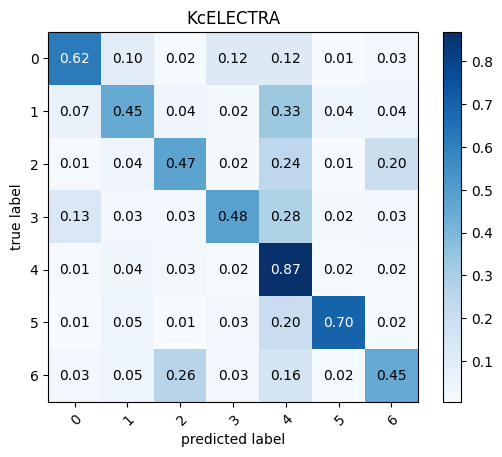

In [ ]:
show_confusion_matrix(KcELECTRA_label_list,KcELECTRA_y_preds,model_name) # confusion matrix

# KoELECTRA 모델
https://github.com/monologg/KoELECTRA

In [22]:
# Load the pre-trained LLM model and tokenizer
model_name = "monologg/koelectra-small-v3-discriminator"
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels =len(target_classes))
model.to(device)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(35000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Li

In [23]:
# dataset
train_dataset = custom_dataset(X_train, Y_train, tokenizer, max_length)
test_dataset = custom_dataset(X_test, Y_test, tokenizer, max_length)

# dataloader
train_data_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_data_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

In [24]:
KoELECTRA_y_preds =[] # confusion matrix
KoELECTRA_label_list =[] # confusion matrix

In [25]:
# model_name =['koBERT','KoELECTRA', 'KcBERT', 'KcELECTRA']
# wandb: 가 안뜨면 런타임 다시 시작 또는 삭제하고 !wandb login '본인 API 키' 다시 실행하고 돌려볼 것
model_name = 'KoELECTRA'
KoELECTRA_label_list, KoELECTRA_y_preds= train_and_validate(model=model,model_name=model_name,
                                                      train_data_loader=train_data_loader,test_data_loader=test_data_loader)

wandb: Currently logged in as: huijunam (team_5g). Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.10
wandb: Run data is saved locally in /content/wandb/run-20230920_050439-skxdy18p
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run KoELECTRA_epoch_5_batch_size_64_learning_rate_5e-05/2023-09-20 05:04:38.233693
wandb: ⭐️ View project at https://wandb.ai/team_5g/KoBERT
wandb: 🚀 View run at https://wandb.ai/team_5g/KoBERT/runs/skxdy18p


  0%|          | 0/1127 [00:00<?, ?it/s]

epoch 1 batch id 1 train loss 1.9422 train acc 0.2500
epoch 1 batch id 201 train loss 1.5288 train acc 0.5131
epoch 1 batch id 401 train loss 1.4368 train acc 0.5182
epoch 1 batch id 601 train loss 1.3830 train acc 0.5303
epoch 1 batch id 801 train loss 1.3341 train acc 0.5436
epoch 1 batch id 1001 train loss 1.2861 train acc 0.5590
epoch 1 train loss 1.2598 train acc 0.5663
epoch 1 batch id 1 test loss 0.7590 test acc 0.7656
epoch 1 batch id 201 test loss 1.0175 test acc 0.6381
epoch 1 test loss 1.0202 test acc 0.6377
Time: 209.1243sec


  0%|          | 0/1127 [00:00<?, ?it/s]

epoch 2 batch id 1 train loss 0.9792 train acc 0.5938
epoch 2 batch id 201 train loss 1.0033 train acc 0.6381
epoch 2 batch id 401 train loss 0.9968 train acc 0.6423
epoch 2 batch id 601 train loss 0.9867 train acc 0.6472
epoch 2 batch id 801 train loss 0.9805 train acc 0.6501
epoch 2 batch id 1001 train loss 0.9709 train acc 0.6541
epoch 2 train loss 0.9681 train acc 0.6545
epoch 2 batch id 1 test loss 0.8416 test acc 0.6406
epoch 2 batch id 201 test loss 0.9361 test acc 0.6671
epoch 2 test loss 0.9365 test acc 0.6662
Time: 207.0256sec


  0%|          | 0/1127 [00:00<?, ?it/s]

epoch 3 batch id 1 train loss 1.0787 train acc 0.6250
epoch 3 batch id 201 train loss 0.8963 train acc 0.6814
epoch 3 batch id 401 train loss 0.8912 train acc 0.6804
epoch 3 batch id 601 train loss 0.8907 train acc 0.6812
epoch 3 batch id 801 train loss 0.8877 train acc 0.6830
epoch 3 batch id 1001 train loss 0.8858 train acc 0.6831
epoch 3 train loss 0.8823 train acc 0.6846
epoch 3 batch id 1 test loss 0.9611 test acc 0.7031
epoch 3 batch id 201 test loss 0.9202 test acc 0.6783
epoch 3 test loss 0.9197 test acc 0.6764
Time: 208.0684sec


  0%|          | 0/1127 [00:00<?, ?it/s]

epoch 4 batch id 1 train loss 0.9083 train acc 0.6094
epoch 4 batch id 201 train loss 0.8213 train acc 0.7097
epoch 4 batch id 401 train loss 0.8275 train acc 0.7055
epoch 4 batch id 601 train loss 0.8281 train acc 0.7061
epoch 4 batch id 801 train loss 0.8249 train acc 0.7069
epoch 4 batch id 1001 train loss 0.8251 train acc 0.7061
epoch 4 train loss 0.8224 train acc 0.7062
epoch 4 batch id 1 test loss 0.9072 test acc 0.6094
epoch 4 batch id 201 test loss 0.9292 test acc 0.6737
epoch 4 test loss 0.9244 test acc 0.6746
Time: 208.0605sec


  0%|          | 0/1127 [00:00<?, ?it/s]

epoch 5 batch id 1 train loss 0.9218 train acc 0.6562
epoch 5 batch id 201 train loss 0.7556 train acc 0.7306
epoch 5 batch id 401 train loss 0.7637 train acc 0.7252
epoch 5 batch id 601 train loss 0.7643 train acc 0.7238
epoch 5 batch id 801 train loss 0.7656 train acc 0.7247
epoch 5 batch id 1001 train loss 0.7682 train acc 0.7237
epoch 5 train loss 0.7668 train acc 0.7245
epoch 5 batch id 1 test loss 0.7882 test acc 0.7656
epoch 5 batch id 201 test loss 0.9321 test acc 0.6700
epoch 5 test loss 0.9255 test acc 0.6727
Time: 208.4340sec


<Figure size 800x600 with 0 Axes>

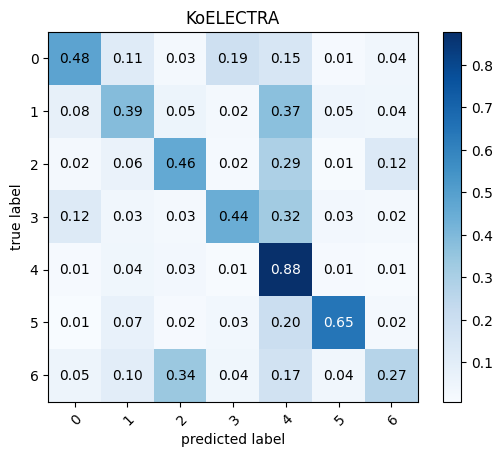

In [26]:
show_confusion_matrix(KoELECTRA_label_list,KoELECTRA_y_preds,model_name) # confusion matrix

In [ ]:
# # wandb_init
# wandb_init(model='KoELECTRA') # model_list =['koBERT','KoELECTRA', 'KcBERT', 'KcELECTRA']

# # watch model
# wandb.watch(model)
# for e in range(num_epochs):
#   train_acc = 0.0
#   test_acc = 0.0
#   train_loss =0.0
#   test_loss =0.0

#   start_time = time.time() # time

#   model.train() #train
#   for batch_id, batch in enumerate(tqdm(train_data_loader)):
#     input_ids = batch['input_ids']
#     attention_mask = batch['attention_mask']
#     labels = batch['labels']

#     input_ids = input_ids.to(device)
#     attention_mask = attention_mask.to(device)
#     labels = labels.to(device)

#     # 그래디언트 초기화
#     optimizer.zero_grad()
#     # 모델에 입력을 주어 예측을 생성합니다.
#     outputs = model(input_ids, attention_mask=attention_mask)
#     # 모델 출력에서 로짓(분류에 대한 점수)을 얻습니다.
#     # 모델 예측
#     logits = outputs.logits  # 최신 Transformers 라이브러리에서는 이렇게 사용할 수 있을 수 있음
#     # 손실을 계산합니다.
#     loss = criterion(logits, labels)
#     # 역전파를 통해 그래디언트 계산
#     loss.backward()
#     # 에포크 전체 손실을 누적합니다.
#     train_loss += loss.item()
#     # 옵티마이저를 사용해 가중치를 업데이트
#     optimizer.step()
#     # 정확도
#     # train_acc += calc_accuracy(np.argmax(logits.cpu().detach().numpy()), label)
#     train_acc += (logits.argmax(dim=1)==labels).sum().item() / (labels.size(0))

#     if batch_id % log_interval == 0:
#       print("epoch {} batch id {} train loss {:.4f} train acc {:.4f}".format(e+1, batch_id+1,train_loss/(batch_id+1),train_acc/(batch_id+1)))

#     # wandb log
#     wandb.log({"train_acc": train_acc/(batch_id+1)}, commit=False)
#     wandb.log({"train_loss": train_loss/(batch_id+1)}, commit=False)
#   # # # wandb log
#   # wandb.log({"train_acc": train_acc/len(train_data_loader)}, commit=False)
#   # wandb.log({"train_loss": train_loss/len(train_data_loader)},commit=False)

#   print("epoch {} train loss {:.4f} train acc {:.4f}".format(e+1,train_loss/(batch_id+1),train_acc/(batch_id+1)))

#   # 모델 평가
#   model.eval()
#   with torch.no_grad():
#     for batch_id, batch in enumerate(test_data_loader):
#       # Validation 데이터 가져오기
#       input_ids = batch['input_ids']
#       attention_mask = batch['attention_mask']
#       labels = batch['labels']

#       input_ids = input_ids.to(device)
#       attention_mask = attention_mask.to(device)
#       labels = labels.to(device)

#       # 모델 예측
#       outputs = model(input_ids, attention_mask=attention_mask)
#       logits = outputs.logits

#       KoELECTRA_y_preds.extend(logits.argmax(dim=1).cpu().numpy()) # for confusion matrix
#       KoELECTRA_label_list.extend(labels.cpu().numpy()) # for confusion matrix true label

#       # 손실 계산
#       loss = criterion(logits,labels)
#       test_loss += loss.item()

#       # 정확도 계산
#       # preds = logits.argmax(dim=1)
#       # test_acc += calc_accuracy(np.argmax(logits), label)
#       test_acc += (logits.argmax(dim=1)==labels).sum().item() / (labels.size(0))
#       if batch_id % log_interval == 0:
#         print("epoch {} batch id {} test loss {:.4f} test acc {:.4f}".format(e+1, batch_id+1,test_loss/(batch_id+1),test_acc/(batch_id+1)))

#       # # wandb log
#       # wandb.log({"val_acc": test_acc/(batch_id+1)}, commit=False)
#       # wandb.log({"val_loss": test_loss/(batch_id+1)},commit=False)
#     # wandb log
#     wandb.log({"val_acc": test_acc/len(test_data_loader)},commit=False)
#     wandb.log({"val_loss": test_loss/len(test_data_loader)})
#     end_time = time.time()
#     print("epoch {} test loss {:.4f} test acc {:.4f}".format(e+1,test_loss/(batch_id+1),test_acc/(batch_id+1)))
#     print("Time: {:.4f}sec".format((end_time - start_time)))

#   # val_avg_loss = val_total_loss / len(test_data_loader)
#   # val_accuracy = correct / total
#   # print(f"Validation Loss: {val_avg_loss:.4f} - Validation Accuracy: {val_accuracy:.4f}")

# KoELECTRA_label_list = np.array(KoELECTRA_label_list)
# KoELECTRA_y_preds = np.array(KoELECTRA_y_preds)

In [ ]:
# torch.save(model.state_dict(), "./KoELECTRA_small_v3_epoch5_.pt")

# 키워드 추출
- 명사, 동사, 형용사

In [ ]:
# !pip install konlpy

In [ ]:
# from konlpy.tag import Okt

In [ ]:
# okt = Okt()
# kor_sentence = '너무 배고파 ㅜㅜ'
# print('OKT 품사 태깅 :', okt.pos(kor_sentence))

OKT 품사 태깅 : [('너무', 'Adverb'), ('배고파', 'Adjective'), ('ㅜㅜ', 'KoreanParticle')]


In [ ]:
# # 명사, 동사, 형용사 추출하기
# keyword = [x for (x, y) in okt.pos(kor_sentence) if y in ['Verb', 'Noun', 'Adjective']]
# print('\nOKT 명사, 동사, 형용사 추출 :', keyword)


OKT 명사, 동사, 형용사 추출 : ['배고파']


# 새로운 문장 테스트

In [ ]:
# target_classes ={
#     '공포': 0,
#     '놀람': 1,
#     '분노': 2,
#     '슬픔': 3,
#     '중립': 4,
#     '행복': 5,
#     '혐오': 6
#   }

In [ ]:
# reverse =dict(map(reversed, target_classes.items()))
# print(reverse)

{0: '공포', 1: '놀람', 2: '분노', 3: '슬픔', 4: '중립', 5: '행복', 6: '혐오'}


In [ ]:
# list(reverse.keys())

[0, 1, 2, 3, 4, 5, 6]

In [ ]:
# predict_and_keword('어제 헤어졌어 ㅜ')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/1 [00:00<?, ?it/s]


OKT 명사, 동사, 형용사 추출 : ['어제', '헤어졌어']


['슬픔', '어제', '헤어졌어']

In [ ]:
# predict_and_keword('진짜 짜증나')

  0%|          | 0/1 [00:00<?, ?it/s]


OKT 명사, 동사, 형용사 추출 : ['진짜', '짜증나']


['분노', '진짜', '짜증나']

In [ ]:
# predict_and_keword('너무 무서워')

  0%|          | 0/1 [00:00<?, ?it/s]


OKT 명사, 동사, 형용사 추출 : ['무서워']


['공포', '무서워']

## 1. 중립 데이터 제거

In [ ]:
# df_data_neut = df_data[df_data['Emotion'] == '중립'] # 확인

In [ ]:
# df_data_drop = df_data[df_data['Emotion'] != '중립']
# df_data_drop # 중복 데이터 제거한 데이터

,Sentence,Emotion
0,언니 동생으로 부르는게 맞는 일인가요..??,공포
1,그냥 내 느낌일뿐겠지?,공포
2,아직너무초기라서 그런거죠?,공포
3,유치원버스 사고 낫다던데,공포
4,근데 원래이런거맞나요,공포
...,...,...
94132,뭐? 다시 한 번 말해봐.,분노
94152,어? 정말요?,놀람
94154,"혹시, 다들 은행 계좌없는 거예요?",놀람
94169,자네는 대체 뭘 하러 왔나! 젖은 생쥐 꼴이 된 나를 보면서 비웃으러 왔나?,분노


In [ ]:
# len(df_data), len(df_data_neut)+len(df_data_drop) # 확인

45578

In [ ]:
# df_data = df_data_drop

In [ ]:
# target_classes ={
#     '공포': 0,
#     '놀람': 1,
#     '분노': 2,
#     '슬픔': 3,
#     # '중립': 4,
#     '행복': 4,
#     '혐오': 5
#   }